FINE-TUNING + AUGMENTATION OF EFFICENTNET

In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2.13.0


In [ ]:
# Load images from the 'items/' folder
img = np.load('data.npy')
label = np.load('labels.npy', allow_pickle=True)
  # Normalize image pixel values to a float range [0, 1]
img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
img = img[...,::-1]
for i in range(len(label)):
    if(label[i] == 'healthy'):
        label[i] = 1
    else:
        label[i] = 0

import collections
counter = collections.Counter(label)
print(counter)


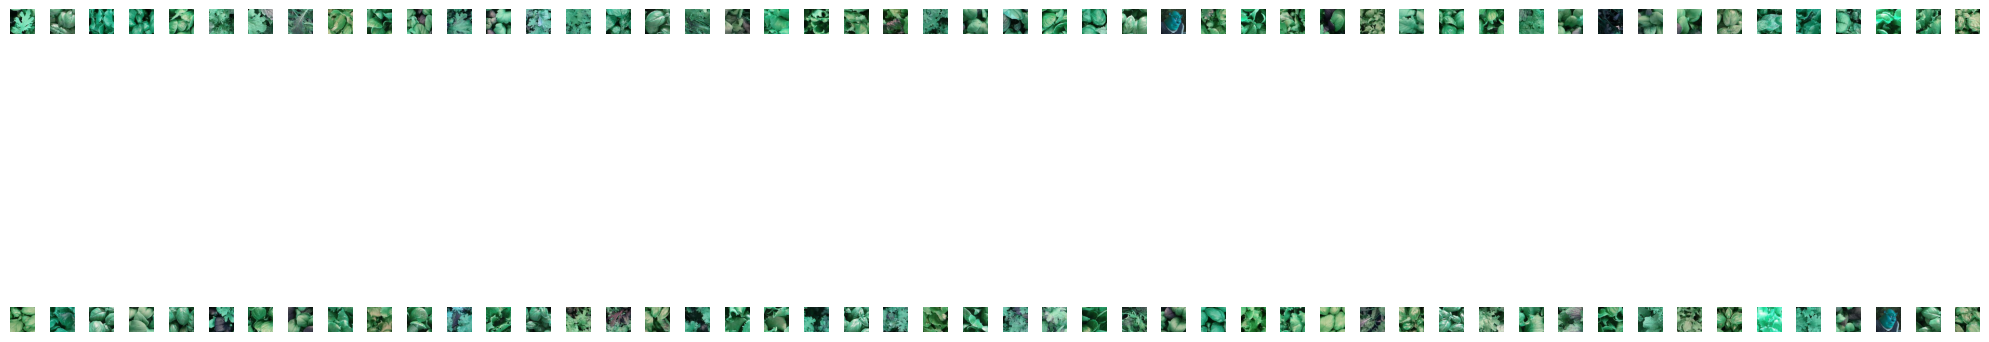

In [12]:
# Number of images to display
num_img = 100
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(img[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = img
# Create labels: 1 for 'animals', 0 for 'items'
y = label

#y = np.concatenate([, np.zeros(len(items))], axis=0)
y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.25, stratify=np.argmax(y, axis = 1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val, axis = 1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape#[1:]
batch_size = 32
epochs = 20

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

X_train shape: (2600, 96, 96, 3), y_train shape: (2600, 2)
X_val shape: (1300, 96, 96, 3), y_val shape: (1300, 2)
X_test shape: (1300, 96, 96, 3), y_test shape: (1300, 2)
Input Shape: (96, 96, 3), Output Shape: (2600, 2), Batch Size: 32, Epochs: 20


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [5]:
def build_model(num_classes):
    inputs = layers.Input(shape=(96, 96, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [9]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]
model = build_model(num_classes=2)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(x = X_train*255, y = y_train, batch_size = batch_size,  epochs=20, validation_data=(X_val*255, y_val), verbose=2)

Epoch 1/20
82/82 - 45s - loss: 1.1757 - accuracy: 0.6992 - val_loss: 0.6772 - val_accuracy: 0.7185 - 45s/epoch - 550ms/step
Epoch 2/20
82/82 - 29s - loss: 1.0624 - accuracy: 0.7127 - val_loss: 0.7482 - val_accuracy: 0.7454 - 29s/epoch - 355ms/step
Epoch 3/20
82/82 - 29s - loss: 0.9973 - accuracy: 0.7358 - val_loss: 0.5048 - val_accuracy: 0.7969 - 29s/epoch - 357ms/step
Epoch 4/20
82/82 - 29s - loss: 0.9955 - accuracy: 0.7242 - val_loss: 0.6436 - val_accuracy: 0.7831 - 29s/epoch - 353ms/step
Epoch 5/20
82/82 - 31s - loss: 0.9334 - accuracy: 0.7327 - val_loss: 0.8044 - val_accuracy: 0.7738 - 31s/epoch - 383ms/step
Epoch 6/20
82/82 - 29s - loss: 0.8399 - accuracy: 0.7335 - val_loss: 0.6314 - val_accuracy: 0.7977 - 29s/epoch - 355ms/step
Epoch 7/20
82/82 - 29s - loss: 0.8032 - accuracy: 0.7335 - val_loss: 0.6122 - val_accuracy: 0.7731 - 29s/epoch - 355ms/step
Epoch 8/20
82/82 - 29s - loss: 0.7649 - accuracy: 0.7369 - val_loss: 0.5552 - val_accuracy: 0.7777 - 29s/epoch - 357ms/step
Epoch 9/

In [10]:
model.save('eff_model')
del model